In [1]:
stt_pecha_tools = "01_stt_pecha_tools.tsv"
prodigy = "02_prodigy.tsv"
mv = "03_mv_saymore.tsv"

In [2]:
import pandas as pd
pecha_tools_df = pd.read_csv(stt_pecha_tools, sep='\t')
prodigy_df = pd.read_csv(prodigy, sep='\t')
mv_df = pd.read_csv(mv, sep='\t')

In [3]:
df = pd.concat([pecha_tools_df, prodigy_df, mv_df], ignore_index=True)

In [4]:
bad_apples = pd.read_csv('04_bad_apples.csv')

In [5]:
df = df[~df['file_name'].isin(bad_apples['file_name'])]

In [6]:
df.drop_duplicates(subset='file_name', keep="first", inplace=True)

# clean the combined tsv

In [7]:
import re
def clean_transcription(text):
    text = text.replace('\n', ' ')
    text = text.replace('\t', ' ')
    text = text.strip()

    text = re.sub(r"་+", "་", text)
    text = re.sub(r"།+", "།", text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"\s+།", "།", text)

    text = re.sub(r"ཧཧཧ+", "ཧཧཧ", text)
    text = re.sub(r'འེ་འེ་(འེ་)+', r'འེ་འེ་འེ་', text)
    text = re.sub(r'ཧ་ཧ་(ཧ་)+', r'ཧ་ཧ་ཧ་', text)

    chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"\“\%\‘\”\�\/\{\}\(\)\༽\》\༼\《\༅\༄\༈\༑\༠]'
    
    text = re.sub(chars_to_ignore_regex, '', text)+" "
    return text

def check_if_regex(text):
    text = str(text)
    regex = re.compile(r'[a-zA-Z]+')
    match = re.search(regex, text)
    
    return bool(match)
    
print(check_if_regex('ཧཧ'))
print(check_if_regex('some text'))

False
True


In [8]:
df = df[df['uni'].str.len() > 0]

In [9]:
df = df[~df['uni'].apply(check_if_regex)]

In [10]:
df['uni'] = df['uni'].map(clean_transcription)

In [11]:
! pip install pyewts

In [12]:
import pyewts

converter = pyewts.pyewts()

df['wylie'] = df['uni'].apply(converter.toWylie)

In [13]:
df['char_len'] = df['uni'].str.len()

In [14]:
! pip install matplotlib

<Axes: >

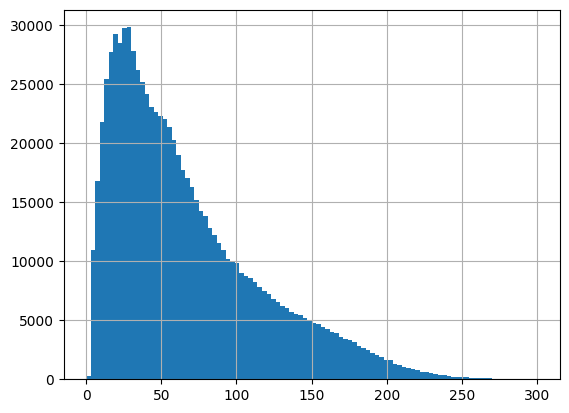

In [15]:
df['char_len'].hist(bins=100, range=(0, 300))

In [16]:
df['char_len'].describe()

count    822757.000000
mean         66.464085
std          60.418673
min           1.000000
25%          28.000000
50%          53.000000
75%          93.000000
max       23249.000000
Name: char_len, dtype: float64

In [17]:
df.shape[0]

822757

In [18]:
upper_cutoff = 400
lower_cutoff = 5

In [19]:
df[df['char_len'] > upper_cutoff].shape[0], df[df['char_len'] < lower_cutoff].shape[0]

(3, 7769)

In [20]:
df[df['char_len'] > upper_cutoff][['uni', 'url', 'char_len']].sort_values(by='char_len').to_csv('04_longer_than_upper_cutoff.tsv', sep='\t', index=False)

In [21]:
df[df['char_len'] < lower_cutoff][['uni', 'url', 'char_len']].sort_values(by='char_len').to_csv('04_shorter_than_lower_cutoff.tsv', sep='\t', index=False)

In [22]:
df = df[(df['char_len'] < upper_cutoff) & (df['char_len'] > lower_cutoff)]

In [23]:
df.shape[0]

811562

In [24]:
def getTimeSpan(filename):

    filename = filename.replace(".wav", "")
    filename = filename.replace(".WAV", "")
    filename = filename.replace(".mp3", "")
    filename = filename.replace(".MP3", "")
    try:
        if "_to_" in filename:
            start, end = filename.split("_to_")
            start = start.split("_")[-1]
            end = end.split("_")[0]
            end = float(end)
            start = float(start)
            return abs(end - start)/1000
        else:
            start, end = filename.split("-")
            start = start.split("_")[-1]
            end = end.split("_")[0]
            end =   float(end)
            start = float(start)
            return abs(end - start)
    except Exception as err:
        print(f"filename is:'{filename}'. Could not parse to get time span.")
        return 0
    

getTimeSpan("STT_TT00031_03471.850-03477.44")

5.5900000000001455

In [25]:
df['audio_len'] = df['file_name'].apply(getTimeSpan)

In [26]:
df['audio_len'].describe()

count    811562.000000
mean          4.231404
std           3.009444
min           0.400000
25%           1.700000
50%           3.224000
75%           6.706000
max          14.050000
Name: audio_len, dtype: float64

<Axes: >

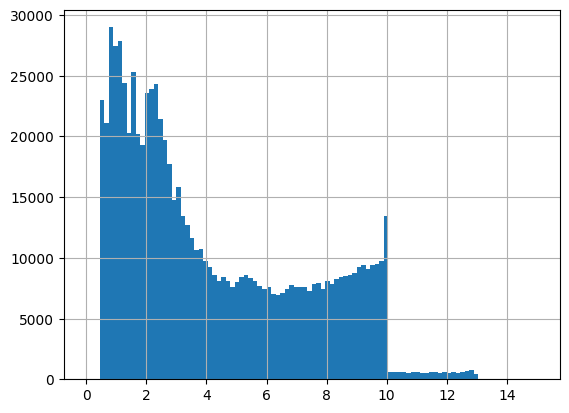

In [27]:
df['audio_len'].hist(bins=100, range=(0, 15))

In [28]:
df['url'] = df['url'].map(lambda x : x.replace('#','%23'))

In [ ]:
! pip install botok

In [29]:
from botok import WordTokenizer

In [30]:
def process_transcript(text, tokenizer):
    tokens = tokenizer.tokenize(text)
    non_word_count = sum(1 for token in tokens if token.pos == 'NON_WORD' and not token.skrt)
    total_tokens = len(tokens)

    non_bo_word_count = 0
    for token in tokens:
        if token.chunk_type in ["LATIN", "CJK", "OTHER"] and (
            token.chunk_type != "OTHER" or not token.skrt
        ):
            non_bo_word_count += 1
    
    return non_word_count, non_bo_word_count, total_tokens

In [36]:
tokenizer = WordTokenizer()

df['non_word_count'], df['non_bo_word_count'], df['total_tokens'] = zip(*df['uni'].apply(lambda text: process_transcript(text, tokenizer)))

Loading Trie... (1s.)


/home/monlamai/Documents/GitHub/stt-combine-datasets/.env/lib/python3.10/site-packages/botok/textunits/bostring.py:82: UserWarning: Beware of unexpected results: input string contains the non-expanded char "བྷ", found in "བྷང".
  warn(
/home/monlamai/Documents/GitHub/stt-combine-datasets/.env/lib/python3.10/site-packages/botok/textunits/bostring.py:82: UserWarning: Beware of unexpected results: input string contains the non-expanded char "བྷ", found in "".
  warn(
/home/monlamai/Documents/GitHub/stt-combine-datasets/.env/lib/python3.10/site-packages/botok/textunits/bostring.py:82: UserWarning: Beware of unexpected results: input string contains the non-expanded char "བྷ", found in "བྷེ་ལ་ཀ".
  warn(
/home/monlamai/Documents/GitHub/stt-combine-datasets/.env/lib/python3.10/site-packages/botok/textunits/bostring.py:82: UserWarning: Beware of unexpected results: input string contains the non-expanded char "གྷ", found in "".
  warn(
/home/monlamai/Documents/GitHub/stt-combine-datasets/.env/lib/py

In [37]:
df.to_csv('04_combine_all.tsv', sep='\t', index=False)

In [47]:
df[ df['non_word_count'] > 1].shape[0], df[ df['non_bo_word_count'] > 1].shape[0]

(31144, 8)

In [59]:
df.shape

(811562, 11)

In [60]:
df['non_word_count'].describe()

count    811562.000000
mean          0.188514
std           0.577201
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          15.000000
Name: non_word_count, dtype: float64

In [58]:
df[ df['non_bo_word_count'] > 1 ].loc[:, ('file_name', 'uni')]

,file_name,uni
82553,STT_NS_M0051_0032_254517_to_261435.mp3,ཨོ་དེ་བསྐོར་ར་རྒྱག་ནས་འགྲོ་དགོས། ཨེ་ནས་ག་ཡིན་ན...
111566,STT_AB00233_0141_1710742_to_1723267,ད་ནི་རྒྱལ་རབས་དངོས་ལ་འཇུག་པར་བྱ་སྟེ། དེ་ཡང་འོག...
111600,STT_AB00233_0191_2287534_to_2300203,དེར་ཤིང་སྡོང་འཛུགས་ཤིང་། ལོ་རེ་བཞིན་དུ་མཆོད་པ་...
117952,STT_AB00233_0146_1763355_to_1776212,མང་ཙམ་ཞིག་པེ་ཅིང་དུ་ཡང་འཁྱེར་ཞེས་ཟེར།╚ག╗རྟགས་ཅ...
122807,STT_AB00233_0163_1979549_to_1991977,སྙམ་དུ་བསམས་སོ། བོད་ཀྱི་གནའ་སྲོལ་དང་རུས་ཁུངས་ས...
123698,STT_AB00233_0287_3486053_to_3498400,སོགས། ╚དཀྱུས╗་དེ་ལྟར་གནམ་རི་སྲོང་བཙན་དུས་ཀྱི་བ...
462420,STT_NS0013_0178_1399114_to_1406151,ང་ཚོ་ལས་ལ་ས་ཡོད་རེད་བ། ནམ་རྒྱུན་ང་ཚོ་ཕར་ལ་ཡ་ཆོ...
568222,STT_AB00221_0059_691510_to_703319,རྒྱ་སྐད་ཀྱི་སྒྲ་གདངས་ཐོག་ནས་བཤད། ད་ལྟ་གཡང་འཛོམ...


In [ ]:
df['non_word_percentage'] = (df['non_word_count'] / df['total_tokens']) * 100
# df.fillna(0, inplace=True)  # Replace NaN values with 0 in case of division by zero

In [61]:
df.to_csv('04_combine_all.tsv', sep='\t', index=False)

In [62]:
df.head()

,file_name,uni,url,dept,grade,wylie,char_len,audio_len,non_word_count,non_bo_word_count,total_tokens
0,STT_AB00237_0190_1711732_to_1723319,ཉི་མ་རིང་ཐུང་ལའང་མ་འདོད་པ་བྱས་ཀྱི་ཡོད་ན་ངས་ཚེ་...,https://huggingface.co/datasets/openpecha/STT_...,STT_AB,2,nyi ma ring thung la'ang ma 'dod pa byas kyi y...,177,11.587,0,0,46
1,STT_AB00237_0197_1767500_to_1776441,ད་ཆ་ཁྱིམ་ཚང་འདི་ལ་འགྲིག་མཐུན་གྱི་ཆ་རྐྱེན་གནས་ཡ...,https://huggingface.co/datasets/openpecha/STT_...,STT_AB,2,da cha khyim tshang 'di la 'grig mthun gyi cha...,131,8.941,0,0,32
2,STT_AB00238_0005_30554_to_39889,དྒྱེ་ནས་ཕ་དོན་གྲུབ་ཀྱི་བསམ་བློའི་ནང་དེ་ནི་ཕལ་ཆ...,https://huggingface.co/datasets/openpecha/STT_...,STT_AB,2,d+g+ye nas pha don grub kyi bsam blo'i nang de...,138,9.335,0,0,32
3,STT_AB00238_0006_41271_to_46288,དེ་ཉིན་གང་ལྟར་དོན་གྲུབ་ཁྱིམ་དུ་སླེབས་མ་ཐག་རང་ག...,https://huggingface.co/datasets/openpecha/STT_...,STT_AB,2,de nyin gang ltar don grub khyim du slebs ma t...,89,5.017,0,0,19
4,STT_AB00238_0007_47056_to_49957,དོན་གྲུབ་རང་སྐྱེས་པ་ཁྱོ་ག་ཞིག་ཡིན་པས་,https://huggingface.co/datasets/openpecha/STT_...,STT_AB,2,don grub rang skyes pa khyo ga zhig yin pas _,38,2.901,0,0,6


In [68]:
df.shape[0]

811562

In [69]:
df[df['non_word_count'] > 1].shape[0] / df.shape[0] * 100

3.837537982310655

In [70]:
df_non_word = df[df['non_word_count'] > 1]

In [80]:
df_non_word.groupby('grade').size()

grade
2    18596
3    12548
dtype: int64

In [88]:
df_non_word.groupby('dept').size()

dept
STT_AB      561
STT_CS     3069
STT_MV    15947
STT_NS     9997
STT_TT     1570
dtype: int64

In [89]:
df_non_word.groupby('dept').sum('audio_len')['audio_len']

dept
STT_AB      5181.794
STT_CS     22756.901
STT_MV    118465.606
STT_NS     74982.277
STT_TT      6560.834
Name: audio_len, dtype: float64

In [77]:
df_non_word.groupby('dept').size() / df.groupby('dept').size() * 100

dept
STT_AB     0.725143
STT_CS     6.807142
STT_MV     6.591058
STT_NS    13.459441
STT_TT     0.421037
dtype: float64

In [79]:
df.groupby('dept').size() / df.shape[0] * 100

dept
STT_AB     9.532728
STT_CS     5.555336
STT_MV    29.812756
STT_NS     9.152104
STT_TT    45.947075
dtype: float64

In [91]:
df_non_word = df_non_word.sort_values(by='non_word_count', ascending=False)

In [ ]:
df_non_word.to_csv('04_non_word_count.tsv', sep='\t', index=False)

In [ ]:
# len(train), len(val), len(test), len(train)+len(val)+len(test), len(df)

In [ ]:
# train.to_csv('train.tsv', sep='\t', index=False)
# val.to_csv(  'val.tsv', sep='\t', index=False)
# test.to_csv( 'test.tsv', sep='\t', index=False)

In [ ]:
df['uni'].str.contains('ཧཧཧ').value_counts()

In [ ]:
import pandas as pd

df = pd.read_csv('04_combine_all.tsv', sep='\t')

In [ ]:
df.head()

In [ ]:
df.groupby('dept')['audio_len'].sum()/60/60

In [ ]:
df['audio_len'].sum()/60/60

In [ ]:
# df.sort_values(by='audio_len', ascending=False, inplace=True)
df = df.sample(frac = 1)

In [ ]:
df.iloc[0:100,[0, 1, 3, 5]].to_csv("04_random_100.tsv", index=False, sep='\t')
df.iloc[0:100,[0, 1, 3, 5]].head()

In [ ]:
df[df['grade'] == 3].groupby('dept').size()